In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [50]:
df = pd.read_csv('../data/icu_ibd_all_table.csv')
df['intime'] = pd.to_datetime(df['intime'])
df.shape

(1161, 32)

In [51]:
df2 = pd.read_csv('../data/patients_ibd.csv')


func = lambda x: pd.to_datetime('{}-01-01'.format(x))
df2['anchor_year'] = df2['anchor_year'].apply(func)

df2.shape

(2417, 6)

In [52]:
data = df.merge(df2[['subject_id', 'anchor_year']], on='subject_id', how='left')
data['age'] = ((data['intime'] - data['anchor_year']).dt.days) / 365 + data['age']

In [5]:
for col in data.columns:
    print(col, end=' ')
    print(data[col].isna().sum(), end=' - ')
    print(len(data[col].unique()))

hadm_id 0 - 1161
subject_id 0 - 683
intime 0 - 1161
outtime 0 - 1161
los 0 - 1159
mortality 0 - 2
gender 0 - 2
age 0 - 1128
weight 1066 - 28
bmi 1070 - 25
heart_rate 1 - 108
systolic_pressure 1099 - 17
diastolic_pressure 1099 - 15
respiratory_rate 1 - 37
temperature 962 - 45
white_blood_cell 1155 - 5
hematocrit 18 - 252
red_blood_cell 705 - 68
rdw 17 - 122
platelet 18 - 454
mcv 17 - 57
mch 17 - 157
hemoglobin 16 - 102
CRP 1161 - 1
race 18 - 25
language 18 - 3
marital_status 32 - 5
insurance 18 - 4
die_in_icu 0 - 2
uc_only 0 - 2
cd_only 0 - 2
uc_cd 0 - 2
anchor_year 0 - 93


In [6]:
cols_except = [
    'hadm_id',
    'subject_id',
    'intime',
    'outtime',
    # 'los',
    'mortality',
    'weight',
    'bmi',
    'systolic_pressure',
    'diastolic_pressure',
    'temperature',
    'white_blood_cell',
    'red_blood_cell',
    'CRP',
    'die_in_icu',
    'anchor_year',
    'uc_cd'
]

cols_include = [col for col in data.columns if col not in cols_except]

data = data[cols_include]

In [7]:
X = data[ ~data[cols_include].isna().any(axis=1) ]


def parse_race(race):
    if 'WHITE' in race:
        return 'WHITE'
    elif 'BLACK' in race:
        return 'BLACK'
    elif 'HISPANIC' in race or 'LATINO' in race:
        return 'HISPANIC/LATINO'
    elif 'ASIAN' in race:
        return 'ASIAN'
    else:
        return 'OTHER'


X.loc[:, 'race'] = X['race'].apply(parse_race)

for col in ['language', 'race', 'marital_status', 'insurance']:
    print(X[col].value_counts())

X = pd.get_dummies(X, columns=['race', 'language', 'marital_status', 'insurance'], prefix=['race', 'language', 'marital_status', 'insurance'])

language
ENGLISH    1056
?            52
Name: count, dtype: int64
race
WHITE              918
BLACK              101
OTHER               61
HISPANIC/LATINO     21
ASIAN                7
Name: count, dtype: int64
marital_status
MARRIED     510
SINGLE      367
WIDOWED     136
DIVORCED     95
Name: count, dtype: int64
insurance
Medicare    516
Other       505
Medicaid     87
Name: count, dtype: int64


In [123]:
cols = ['age', 'heart_rate', 'respiratory_rate', 'hematocrit', 'rdw',
       'platelet', 'mcv', 'mch', 'hemoglobin',]

tmp = X.loc[:, cols]

# tmp = ( tmp - tmp.mean() ) / ( tmp.std() )
tmp = ( tmp - tmp.min() ) / ( tmp.max() - tmp.min() )

X.loc[:, cols] = tmp

In [124]:
X.loc[:, [col for col in X.columns if col not in cols+['los']]] = \
    X.loc[:, [col for col in X.columns if col not in cols+['los']]].astype(int)

C:\Users\sitdo\AppData\Local\Temp\ipykernel_24428\2195305398.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X.loc[:, [col for col in X.columns if col not in cols+['los']]] = \
C:\Users\sitdo\AppData\Local\Temp\ipykernel_24428\2195305398.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X.loc[:, [col for col in X.columns if col not in cols+['los']]] = \
C:\Users\sitdo\AppData\Local\Temp\ipykernel_24428\2195305398.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dty

In [125]:
X['los'] = np.log(X['los'] + 1)

X.to_csv('../new r scripts/data_norm.csv')

In [126]:
X.describe()

,los,gender,age,heart_rate,respiratory_rate,hematocrit,rdw,platelet,mcv,mch,...,race_WHITE,language_?,language_ENGLISH,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_WIDOWED,insurance_Medicaid,insurance_Medicare,insurance_Other
count,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,...,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000,1108.000000
mean,1.189588,0.456679,0.560737,0.400874,0.384928,0.452366,0.610529,0.214194,0.742558,0.726275,...,0.828520,0.046931,0.953069,0.085740,0.460289,0.331227,0.122744,0.078520,0.465704,0.455776
std,0.614112,0.498345,0.201272,0.123302,0.115351,0.133196,0.095449,0.138624,0.070521,0.077567,...,0.377098,0.211587,0.211587,0.280106,0.498646,0.470867,0.328291,0.269109,0.499048,0.498265
min,0.143188,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.735428,0.000000,0.428045,0.312500,0.300000,0.355140,0.541667,0.122449,0.704918,0.683047,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.058509,0.000000,0.561921,0.393750,0.370000,0.441589,0.594697,0.189885,0.737705,0.729730,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.474313,1.000000,0.723528,0.475000,0.440000,0.535047,0.659091,0.267968,0.780738,0.771499,...,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,3.958028,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


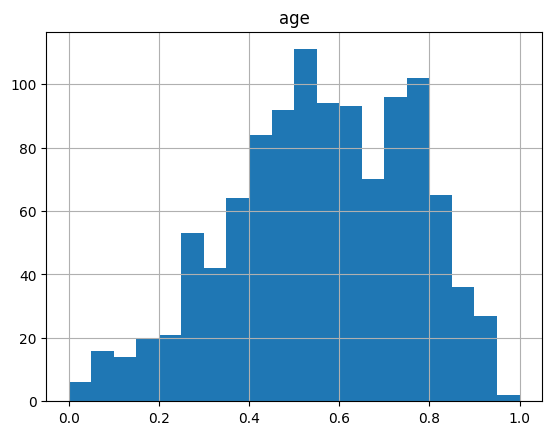

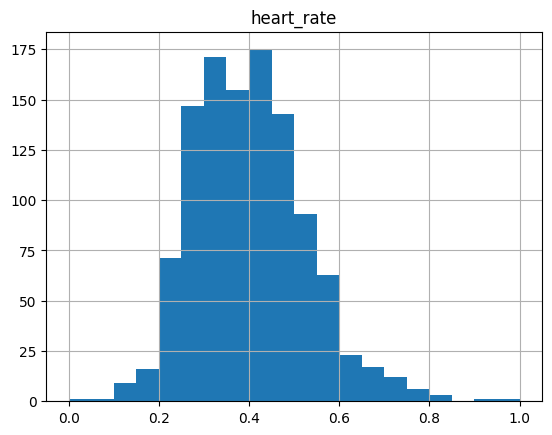

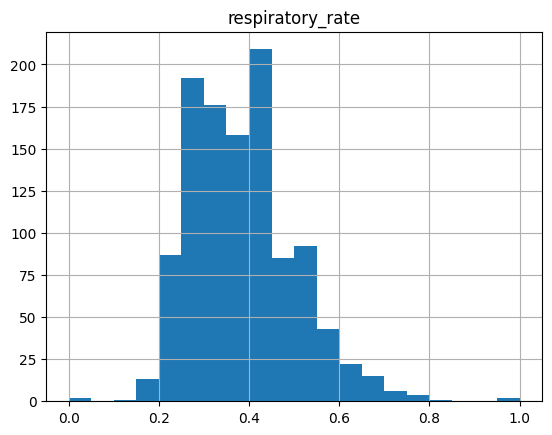

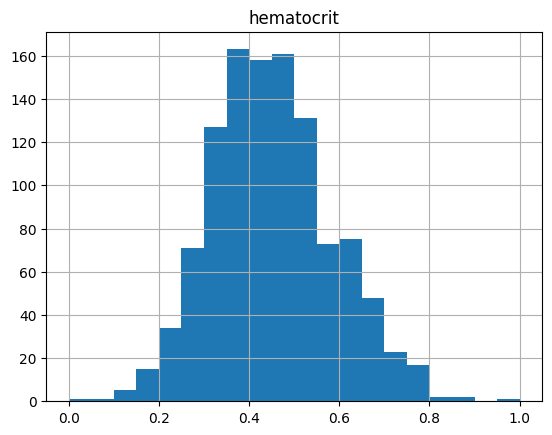

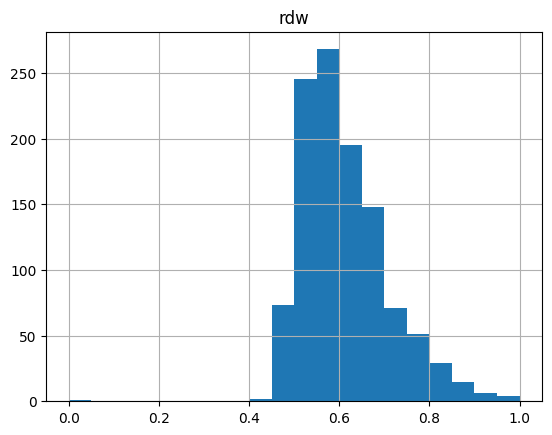

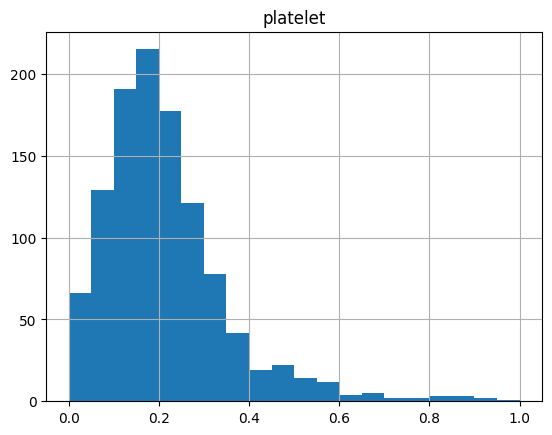

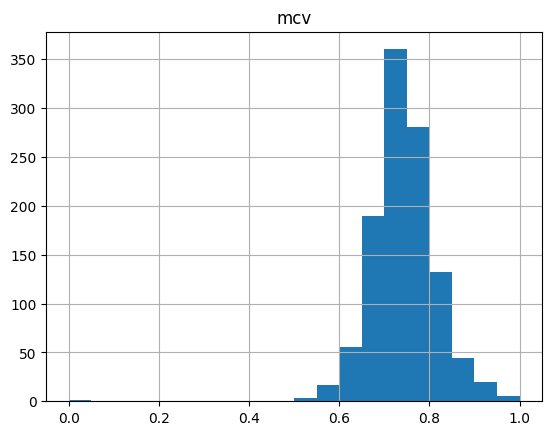

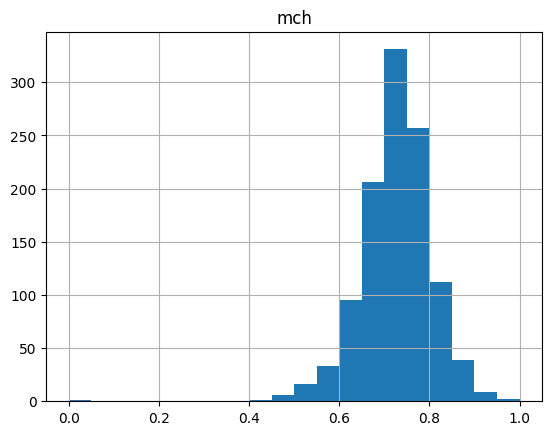

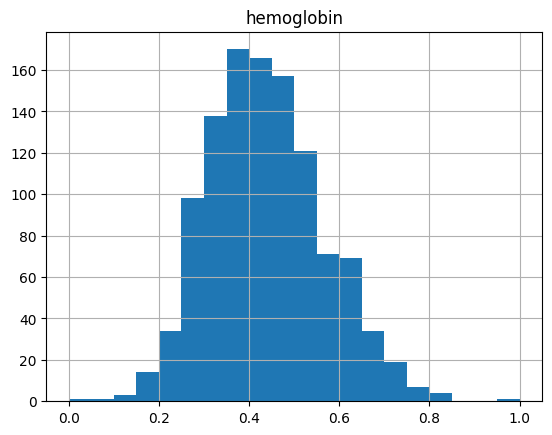

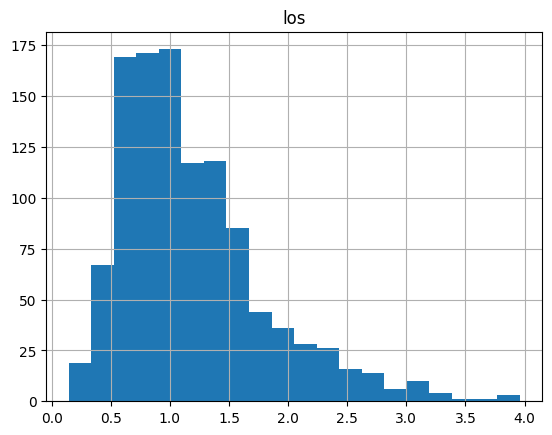

In [127]:
for col in cols+['los']:
    # plt.boxplot(X[col])
    X[col].hist(bins=20)
    plt.title(col)
    plt.show()

<Axes: >

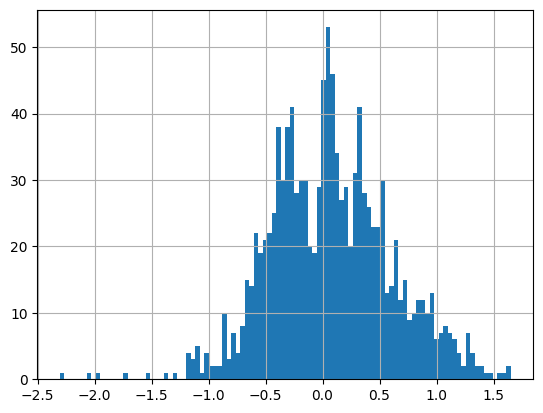

In [47]:
data['los'].hist(bins=100)

In [43]:
data['los'] = np.log(data['los']+1)

In [44]:
_ = (data['los'] - data['los'].mean()) / data['los'].std()
_ = _[~((_ > 3) | (_ < -3))]

In [45]:
import pandas as pd
from scipy import stats

# 假设你已经有了一个Pandas DataFrame `df` 和一个列名 `column_name`

# 确保这一列中的所有值都大于0
# 如果有零或负数，你需要先对数据进行平移
# 例如：df['column_name'] = df['column_name'] + 1

# 应用Box-Cox转换
data['los'], fitted_lambda = stats.boxcox(data['los'])

# 打印转换后的列和找到的lambda值
print(data['los'])
print(f"找到的lambda值: {fitted_lambda}")


0      -0.564868
1      -0.306223
2       0.103936
3      -0.199492
4       0.363980
          ...   
1156    0.275207
1157    0.835922
1158   -0.426044
1159   -0.317920
1160   -0.226149
Name: los, Length: 1161, dtype: float64
找到的lambda值: 0.25802751636860205


In [46]:
from scipy.stats import normaltest

stat, p = normaltest(data['los'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# 解读结果
if p > 0.05:
    print('样本看起来是正态分布的')
else:
    print('样本看起来不是正态分布的')


Statistics=8.862, p=0.012
样本看起来不是正态分布的


In [48]:
data

,hadm_id,subject_id,intime,outtime,los,mortality,gender,age,weight,bmi,...,CRP,race,language,marital_status,insurance,die_in_icu,uc_only,cd_only,uc_cd,anchor_year
0,20004577,14583219,2164-07-15 04:11:42,2164-07-15 21:30:20,-0.564868,0,0,34.539726,NaN,NaN,...,NaN,WHITE,ENGLISH,MARRIED,Other,0,1,0,0,2160-01-01
1,20007037,16147352,2129-11-14 14:43:18,2129-11-15 16:22:06,-0.306223,0,1,58.868493,153.00,NaN,...,NaN,WHITE,ENGLISH,DIVORCED,Other,0,1,0,0,2129-01-01
2,20030062,14887253,2127-06-05 14:10:01,2127-06-07 14:50:49,0.103936,1,0,63.427397,NaN,NaN,...,NaN,WHITE,ENGLISH,DIVORCED,Other,0,0,1,0,2121-01-01
3,20033189,14685940,2127-07-31 14:46:00,2127-08-01 20:58:34,-0.199492,1,0,77.578082,147.30,28.8,...,NaN,WHITE,ENGLISH,MARRIED,Other,0,1,0,0,2126-01-01
4,20033924,13158454,2196-04-28 11:28:47,2196-05-01 14:22:54,0.363980,1,0,75.328767,184.08,33.7,...,NaN,BLACK/AFRICAN AMERICAN,ENGLISH,SINGLE,Other,0,0,1,0,2185-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156,29968343,13050725,2167-09-23 10:56:17,2167-09-26 03:24:17,0.275207,1,0,67.728767,162.00,27.8,...,NaN,WHITE,ENGLISH,SINGLE,Medicare,1,0,1,0,2161-01-01
1157,29978132,12626863,2172-11-25 18:52:00,2172-12-03 05:10:40,0.835922,1,1,75.901370,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,1,0,0,2172-01-01
1158,29984287,12251785,2179-01-10 18:40:00,2179-01-11 16:02:09,-0.426044,0,0,59.027397,112.70,23.2,...,NaN,WHITE,ENGLISH,SINGLE,Medicare,1,0,1,0,2175-01-01
1159,29988959,12845930,2118-11-08 12:07:00,2118-11-09 13:18:33,-0.317920,1,1,73.852055,NaN,NaN,...,NaN,WHITE,ENGLISH,MARRIED,Medicare,1,1,0,0,2118-01-01


1. 总共的 los mean, std | UC nums, los mean std | CD nums, los mean std , gender

In [54]:
data['subject_id'].unique().shape

(683,)

In [82]:
pd.pivot_table(data, values='los', index='uc_only', aggfunc=['mean', 'std'])

,mean,std
,los,los
uc_only,,
0,2.981618,3.970484
1,3.421070,4.850756


In [66]:
data[data['uc_cd'] == 1]['subject_id'].unique().shape

(34,)

In [68]:
data.groupby('subject_id').agg({
    'los': 'mean'
}).mean(), data.groupby('subject_id').agg({
    'los': 'mean'
}).std()

(los    3.124294
 dtype: float64,
 los    3.472483
 dtype: float64)

In [69]:
data['los'].mean(), data['los'].std(), 

(3.179958045994832, 4.393176753010088)

In [83]:
data.groupby('subject_id').agg({
    'gender': 'first'
}).value_counts()

gender
0         356
1         327
Name: count, dtype: int64

In [77]:
data['die_in_icu'].sum()

160

In [78]:
x1 = data[data['uc_only'] == 1]['los']
x2 = data[data['cd_only'] == 1]['los']

In [79]:
x1 = np.array(x1)
x2 = np.array(x2)

In [80]:
import numpy as np
from scipy import stats

# 假设x1和x2是两个numpy数组，代表两组独立的观察值
#x1 = np.array([...])
#x2 = np.array([...])

# 曼-惠特尼U检验
u_statistic, p_value = stats.mannwhitneyu(x1, x2, alternative='two-sided')

print(f"U统计量: {u_statistic}")
print(f"P值: {p_value}")

# 根据P值判断显著性
if p_value < 0.05:
    print("两组数据的中位数存在显著差异。")
else:
    print("两组数据的中位数不存在显著差异。")


U统计量: 156294.0
P值: 0.20052941885702036
两组数据的中位数不存在显著差异。


In [84]:
import numpy as np
from scipy import stats

# 假设x1和x2是两个numpy数组，代表两组独立的观察值
#x1 = np.array([...])
#x2 = np.array([...])

# 进行独立样本t检验
t_statistic, p_value = stats.ttest_ind(x1, x2, equal_var=False)

print(f"t统计量: {t_statistic}")
print(f"P值: {p_value}")

# 根据P值判断显著性
if p_value < 0.05:
    print("两组数据的均值存在显著差异。")
else:
    print("两组数据的均值不存在显著差异。")


t统计量: 1.5910403708286358
P值: 0.11191213446977967
两组数据的均值不存在显著差异。
